# Homework 2

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

In [2]:
data = pd.read_excel("../data/treasury_ts_2015-08-15.xlsx", sheet_name = "database")
data = data[(data["kytreasno"] == 204046) | (data["kytreasno"] == 204047)]
data = data[data["caldt"] == "2008-11-04"].set_index("kytreasno")
data["tdcouprt"] = [4.25, 10.625]
data

,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg,tdcouprt
kytreasno,,,,,,,,,,,,,,,,,
204047,2.015082e+07,2008-11-04,105.953125,105.984375,105.96875,M,X,0.935462,0.011642,0.000089,2168.016569,20998.0,32470.0,0.0,NaN,NaN,4.250
204046,2.015082e+07,2008-11-04,141.859375,141.890625,141.87500,M,X,2.338655,0.009720,0.000098,1910.307862,2852.0,4024.0,0.0,NaN,NaN,10.625


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

In [3]:
chart = data.loc[:, ["tdbid", "tdask", "tdnomprc", "tdcouprt", "tdyld", "tdaccint", "tdduratn"]]
chart.columns = ["Bid", "Ask", "Price", "Coupon Rate", "YTM", "Accrued Interest", "Duration"]
chart["Duration"] = chart["Duration"]/365.25
chart["Dirty Price"] = chart["Price"] + chart["Accrued Interest"]
chart["YTM"] = chart["YTM"] * 365.25
chart["Modified Duration"] = chart["Duration"] / (1 + chart["YTM"]/2)
chart = chart.T
chart

kytreasno,204047,204046
Bid,105.953125,141.859375
Ask,105.984375,141.890625
Price,105.968750,141.875000
Coupon Rate,4.250000,10.625000
YTM,0.032362,0.035753
Accrued Interest,0.935462,2.338655
Duration,5.935706,5.230138
Dirty Price,106.904212,144.213655
Modified Duration,5.841189,5.138284


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [4]:
N = 50000000

n6 = N / chart[204046]["Dirty Price"]

dd7 = chart[204047]["Duration"] * chart[204047]["Dirty Price"]
dd6 = chart[204046]["Duration"] * chart[204046]["Dirty Price"]

n7 = -n6 * dd6 / dd7

v6 = n6 * chart[204046]["Dirty Price"]
v7 = n7 * chart[204047]["Dirty Price"]

sec0 = pd.DataFrame({
    "Securities": [204046, 204047],
    "Number of Bonds": [n6, n7],
    "Holdings": [v6, v7]
})
sec0 = sec0.set_index("Securities") 
sec0 = sec0.T
sec0

Securities,204046,204047
Number of Bonds,3.467078e+05,-4.121127e+05
Holdings,5.000000e+07,-4.405658e+07


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

We are long in the security where the yield curve is going down and short the security where the yield curve is going up. That means that the security we are long in's price is going up while the the security we are short in's price is going down. This will cause a positive PnL in both sides of the trade since meaning we expect the PnL of the trade to go up.

In [5]:
dytm = 0.5

dc6 = -chart[204046]["Modified Duration"] * chart[204046]["Dirty Price"] * n6 * (-dytm)
dc7 = -chart[204047]["Modified Duration"] * chart[204047]["Dirty Price"] * n7 * (dytm)

print("PnL of the Long Position: " + str(dc6))
print("PnL of the Short Position: " + str(dc7))
print("The Total PnL is " + str(dc6 + dc7))

PnL of the Long Position: 128457105.87914275
PnL of the Short Position: 128671393.2502028
The Total PnL is 257128499.12934554


In [6]:
dytm = (chart[204046]["YTM"] - chart[204047]["YTM"])/2

dc6 = -chart[204046]["Modified Duration"] * chart[204046]["Dirty Price"] * n6 * (-dytm)
dc7 = -chart[204047]["Modified Duration"] * chart[204047]["Dirty Price"] * n7 * (dytm)

print("The Total PnL is " + str(dc6 + dc7))

The Total PnL is 871745.6675100932


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

### 2008-11-25

In [8]:
data2 = pd.read_excel("../data/treasury_ts_2015-08-15.xlsx", sheet_name = "database")
data2 = data2[(data2["kytreasno"] == 204046) | (data2["kytreasno"] == 204047)]
data2 = data2[data2["caldt"] == "2008-11-25"].set_index("kytreasno")
data2["tdcouprt"] = [4.25, 10.625]
data2

,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg,tdcouprt
kytreasno,,,,,,,,,,,,,,,,,
204047,2.015082e+07,2008-11-25,110.796875,110.828125,110.8125,M,X,1.177989,0.011821,0.000068,2155.590747,20998.0,32470.0,0.0,NaN,NaN,4.250
204046,2.015082e+07,2008-11-25,145.859375,145.890625,145.8750,M,X,2.944973,0.006642,0.000082,1898.970318,2852.0,4024.0,0.0,NaN,NaN,10.625


In [9]:
chart2 = data2.loc[:, ["tdbid", "tdask", "tdnomprc", "tdcouprt", "tdyld", "tdaccint", "tdduratn"]]
chart2.columns = ["Bid", "Ask", "Price", "Coupon Rate", "YTM", "Accrued Interest", "Duration"]
chart2["Duration"] = chart2["Duration"]/365.25
chart2["Dirty Price"] = chart2["Price"] + chart2["Accrued Interest"]
chart2["YTM"] = chart2["YTM"] * 365.25
chart2["Modified Duration"] = chart2["Duration"] / (1 + chart2["YTM"]/2)
chart2 = chart2.T
chart2

kytreasno,204047,204046
Bid,110.796875,145.859375
Ask,110.828125,145.890625
Price,110.812500,145.875000
Coupon Rate,4.250000,10.625000
YTM,0.024787,0.030086
Accrued Interest,1.177989,2.944973
Duration,5.901686,5.199097
Dirty Price,111.990489,148.819973
Modified Duration,5.829439,5.122046


In [10]:
dytm6 = chart2[204046]["YTM"] - chart[204046]["YTM"]
dytm7 = chart2[204047]["YTM"] - chart[204047]["YTM"]

dc6 = -chart[204046]["Modified Duration"] * chart[204046]["Dirty Price"] * n6 * (dytm6)
dc7 = -chart[204047]["Modified Duration"] * chart[204047]["Dirty Price"] * n7 * (dytm7)

dp6 = (chart2[204046]["Dirty Price"] - chart[204046]["Dirty Price"]) * n6
dp7 = (chart2[204047]["Dirty Price"] - chart[204047]["Dirty Price"]) * n7

print("The Total PnL change using Duration is " + str(dc6 + dc7))
print("The Acutal Total PnL change " + str(dp6 + dp7))

The Total PnL change using Duration is -493714.83298910083
The Acutal Total PnL change -499072.8163001358


### 2008-12-16

In [13]:
data3 = pd.read_excel("../data/treasury_ts_2015-08-15.xlsx", sheet_name = "database")
data3 = data3[(data3["kytreasno"] == 204046) | (data3["kytreasno"] == 204047)]
data3 = data3[data3["caldt"] == "2008-12-16"].set_index("kytreasno")
data3["tdcouprt"] = [4.25, 10.625]
data3

,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg,tdcouprt
kytreasno,,,,,,,,,,,,,,,,,
204047,2.015082e+07,2008-12-16,117.500000,117.531250,117.515625,M,X,1.420516,0.015034,0.00004,2145.587039,20998.0,32470.0,0.0,NaN,NaN,4.250
204046,2.015082e+07,2008-12-16,151.921875,151.953125,151.937500,M,X,3.551291,0.013015,0.00006,1891.661357,2852.0,4024.0,0.0,NaN,NaN,10.625


In [14]:
chart3 = data3.loc[:, ["tdbid", "tdask", "tdnomprc", "tdcouprt", "tdyld", "tdaccint", "tdduratn"]]
chart3.columns = ["Bid", "Ask", "Price", "Coupon Rate", "YTM", "Accrued Interest", "Duration"]
chart3["Duration"] = chart3["Duration"]/365.25
chart3["Dirty Price"] = chart3["Price"] + chart3["Accrued Interest"]
chart3["YTM"] = chart3["YTM"] * 365.25
chart3["Modified Duration"] = chart3["Duration"] / (1 + chart3["YTM"]/2)
chart3 = chart3.T
chart3

kytreasno,204047,204046
Bid,117.500000,151.921875
Ask,117.531250,151.953125
Price,117.515625,151.937500
Coupon Rate,4.250000,10.625000
YTM,0.014760,0.021927
Accrued Interest,1.420516,3.551291
Duration,5.874297,5.179087
Dirty Price,118.936141,155.488791
Modified Duration,5.831261,5.122922


In [15]:
dytm6 = chart3[204046]["YTM"] - chart[204046]["YTM"]
dytm7 = chart3[204047]["YTM"] - chart[204047]["YTM"]

dc6 = -chart[204046]["Modified Duration"] * chart[204046]["Dirty Price"] * n6 * (dytm6)
dc7 = -chart[204047]["Modified Duration"] * chart[204047]["Dirty Price"] * n7 * (dytm7)

dp6 = (chart3[204046]["Dirty Price"] - chart[204046]["Dirty Price"]) * n6
dp7 = (chart3[204047]["Dirty Price"] - chart[204047]["Dirty Price"]) * n7

print("The Total PnL change using Duration is " + str(dc6 + dc7))
print("The Acutal Total PnL change " + str(dp6 + dp7))

The Total PnL change using Duration is -977619.5567310792
The Acutal Total PnL change -1049332.7543288777


It makes sense for the change for 2008-11-25 since there was a smaller change in the yield curve. However, due to larger magnitude of the change in the YTM for 2008-12-16, there was a greater discrepency in the actual PnL and the PnL corresponding to the YTM spread. This is why we see there be a greater difference in the Acutal PnL and PnL using duration for 2008-12-16 compared to 2008-11-25. So the sensitivity makes sense for 2008-11-25 but less so for 2008-12-16. However, both make sense overall as we see there be a not so big difference in our PnL relative to our total notional size, so I say that the sensitivityu makes sense.

## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [19]:
def summarizing_stats(date):
    data2 = pd.read_excel("../data/treasury_ts_2015-08-15.xlsx", sheet_name = "database")
    data2 = data2[(data2["kytreasno"] == 204046) | (data2["kytreasno"] == 204047)]
    data2 = data2[data2["caldt"] == date].set_index("kytreasno")
    data2["tdcouprt"] = [4.25, 10.625]
    
    chart2 = data2.loc[:, ["tdbid", "tdask", "tdnomprc", "tdcouprt", "tdyld", "tdaccint", "tdduratn"]]
    chart2.columns = ["Bid", "Ask", "Price", "Coupon Rate", "YTM", "Accrued Interest", "Duration"]
    chart2["Duration"] = chart2["Duration"]/365.25
    chart2["Dirty Price"] = chart2["Price"] + chart2["Accrued Interest"]
    chart2["YTM"] = chart2["YTM"] * 365.25
    chart2["Modified Duration"] = chart2["Duration"] / (1 + chart2["YTM"]/2)
    chart2 = chart2.T
    return chart2

In [20]:
def ytm_spread_pchange(d1, d2, n1, n2):
    chart = summarizing_stats(d1)
    chart3 = summarizing_stats(d2)
    
    dytm6 = chart3[204046]["YTM"] - chart[204046]["YTM"]
    dytm7 = chart3[204047]["YTM"] - chart[204047]["YTM"]

    dc6 = -chart[204046]["Modified Duration"] * chart[204046]["Dirty Price"] * n1 * (dytm6)
    dc7 = -chart[204047]["Modified Duration"] * chart[204047]["Dirty Price"] * n2 * (dytm7)
    
    return dc6 + dc7

def pchange(d1, d2, n1, n2):
    chart = summarizing_stats(d1)
    chart3 = summarizing_stats(d2)

    dp6 = (chart3[204046]["Dirty Price"] - chart[204046]["Dirty Price"]) * n6
    dp7 = (chart3[204047]["Dirty Price"] - chart[204047]["Dirty Price"]) * n7
    
    return dp6 + dp7

In [21]:
#2009-01-27
d1 = "2008-11-04"
d2 = "2009-01-27"
n1 = n6
n2 = n7

print("The Total PnL change using Duration is " + str(ytm_spread_pchange(d1, d2, n1, n2)))
print("The Acutal Total PnL change " + str(pchange(d1, d2, n1, n2)))

The Total PnL change using Duration is -43034.39659745293
The Acutal Total PnL change 20657.359719127417


In [22]:
#2009-03-24
d1 = "2008-11-04"
d2 = "2009-03-24"
n1 = n6
n2 = n7

print("The Total PnL change using Duration is " + str(ytm_spread_pchange(d1, d2, n1, n2)))
print("The Acutal Total PnL change " + str(pchange(d1, d2, n1, n2)))

The Total PnL change using Duration is 299670.7893288643
The Acutal Total PnL change -545508.2272031135


In [23]:
#2009-06-16
d1 = "2008-11-04"
d2 = "2009-06-16"
n1 = n6
n2 = n7

print("The Total PnL change using Duration is " + str(ytm_spread_pchange(d1, d2, n1, n2)))
print("The Acutal Total PnL change " + str(pchange(d1, d2, n1, n2)))

The Total PnL change using Duration is 1053594.4405110432
The Acutal Total PnL change 234164.91457239824


The trade did well in the first 6 months of 2009 since our total PnL actually went up to 237k in June after dipping to -523k in March. Since our overall PnL went up, I believe that the trade performed well. However, our the ytm spread doesn't correspond to what we would expect since we see massive price discrepencies between the actual PnL and the price change using the Duration. So using the same calculation from 1.3 doesn't work anymore.

***

# 2 Hedging Duration

Use data from `../data/treasury_ts_duration_2024-10-31.xlsx`.

The file contains time-series information on two treasuries. Observe the info of the securities with the following code:


In [24]:
import pandas as pd

In [25]:
data = pd.read_excel("../data/treasury_ts_duration_2024-10-31.xlsx",sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.625
207392,bond,2019-08-15,2049-08-15,2.250


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [27]:
SHEET_PRICE = 'price'
SHEET_DURATION = 'duration'
INDEX_NAME = 'quote date'

price = pd.read_excel("../data/treasury_ts_duration_2024-10-31.xlsx",sheet_name=SHEET_PRICE).set_index(INDEX_NAME)
duration = pd.read_excel("../data/treasury_ts_duration_2024-10-31.xlsx",sheet_name=SHEET_DURATION).set_index(INDEX_NAME)

display(price)
display(duration)

,207391,207392
quote date,,
2019-08-09,98.882812,99.789062
2019-08-12,99.796875,102.554688
2019-08-13,99.281250,101.867188
2019-08-14,100.406250,105.179688
2019-08-15,100.882812,106.234375
...,...,...
2024-11-22,88.740234,63.722656
2024-11-25,89.287109,65.378906
2024-11-26,89.214844,65.175781


,207391,207392
quote date,,
2019-08-09,9.289497,22.000102
2019-08-12,9.285468,22.118496
2019-08-13,9.280314,22.084308
2019-08-14,9.282750,22.228549
2019-08-15,9.282163,22.270910
...,...,...
2024-11-22,4.539445,17.205511
2024-11-25,4.531983,17.312267
2024-11-26,4.529132,17.295472


### 2.1.

Suppose you have a portfolio of `10,000` USD long in security `207391` on the first day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

In [28]:
N = 10000

tdata = price.join(duration, lsuffix='_price', rsuffix='_duration')
tdata["n_207391"] = N/tdata["207391_price"]
tdata["n_207392"] = - tdata["n_207391"] * (tdata["207391_price"] * tdata["207391_duration"])/(tdata["207392_price"] * tdata["207392_duration"])
tdata.head(1)

,207391_price,207392_price,207391_duration,207392_duration,n_207391,n_207392
quote date,,,,,,
2019-08-09,98.882812,99.789062,9.289497,22.000102,101.12981,-42.314047


In [29]:
sh_po = tdata["n_207392"][0] * tdata["207392_price"][0]
lo_po = tdata["n_207391"][0] * tdata["207391_price"][0]
dic = {"Short Position": sh_po, "Long Position": lo_po}
dic

{'Short Position': -4222.479082922904, 'Long Position': 10000.0}

### 2.2.

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be `10,000`.
* Repeat throughout the timeseries.

Calculate the daily profit and loss (PnL) for the
* dynamically hedged position constructed above.
* long-only position, (still at `10,000` throughout.)

(You might check to verify that the net duration is zero at all dates.)

Report...
* the cumulative PnL of both strategies via a plot.
* the (daily) mean, standard deviation, min, and max of the PnL in a table.

In [30]:
position = pd.DataFrame(index=duration.index, dtype=float)
position["Long"] = N/tdata["207391_price"]
position["Short"] = -position["Long"] * (tdata["207391_price"] * tdata["207391_duration"])/(tdata["207392_price"] * tdata["207392_duration"])
position["Long Value"] = position["Long"] * tdata["207391_price"]
position["Short Value"] = position["Short"] * tdata["207392_price"]
position["Long Trade"] = position["Long"] * tdata["207391_price"].shift(-1)
position["Short Trade"] = position["Short"] * tdata["207392_price"].shift(-1)
position["Long Profit"] = position["Long Trade"] - position["Long Value"]
position["Short Profit"] = position["Short Trade"] - position["Short Value"]
position["Total PnL"] = position["Long Profit"] + position["Short Profit"]
position["Total Cumulative PnL"] = position["Total PnL"].cumsum()
position["Long Cumulative PnL"] = position["Long Profit"].cumsum()
position

,Long,Short,Long Value,Short Value,Long Trade,Short Trade,Long Profit,Short Profit,Total PnL,Total Cumulative PnL,Long Cumulative PnL
quote date,,,,,,,,,,,
2019-08-09,101.129810,-42.314047,10000.0,-4222.479083,10092.438967,-4339.503869,92.438967,-117.024786,-24.585820,-24.585820,92.438967
2019-08-12,100.203538,-40.934802,10000.0,-4198.055835,9948.332550,-4169.913158,-51.667450,28.142676,-23.524773,-48.110593,40.771517
2019-08-13,100.723953,-41.251958,10000.0,-4202.220951,10113.314448,-4338.868062,113.314448,-136.647111,-23.332664,-71.443256,154.085965
2019-08-14,99.595394,-39.703946,10000.0,-4176.048586,10047.463430,-4217.923841,47.463430,-41.875255,5.588175,-65.855082,201.549394
2019-08-15,99.124913,-39.232518,10000.0,-4167.842047,9975.993185,-4110.525790,-24.006815,57.316257,33.309442,-32.545640,177.542580
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22,112.688456,-41.403909,10000.0,-2638.367073,10061.626499,-2706.942298,61.626499,-68.575225,-6.948725,69.707573,-888.854491
2024-11-25,111.998250,-40.040242,10000.0,-2617.787204,9991.906379,-2609.654032,-8.093621,8.133172,0.039551,69.747124,-896.948112
2024-11-26,112.088971,-40.178741,10000.0,-2618.680845,10024.957304,-2637.985475,24.957304,-19.304630,5.652675,75.399799,-871.990808


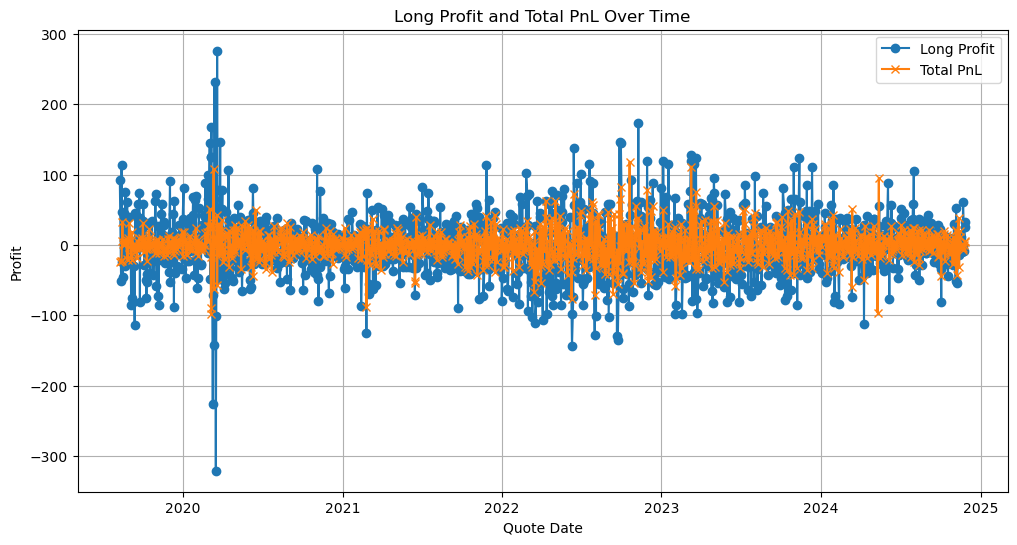

In [31]:
position.index = pd.to_datetime(position.index)

plt.figure(figsize=(12, 6))
plt.plot(position.index, position['Long Profit'], label='Long Profit', linestyle='-', marker='o')
plt.plot(position.index, position['Total PnL'], label='Total PnL', linestyle='-', marker='x')
plt.title('Long Profit and Total PnL Over Time')
plt.xlabel('Quote Date')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

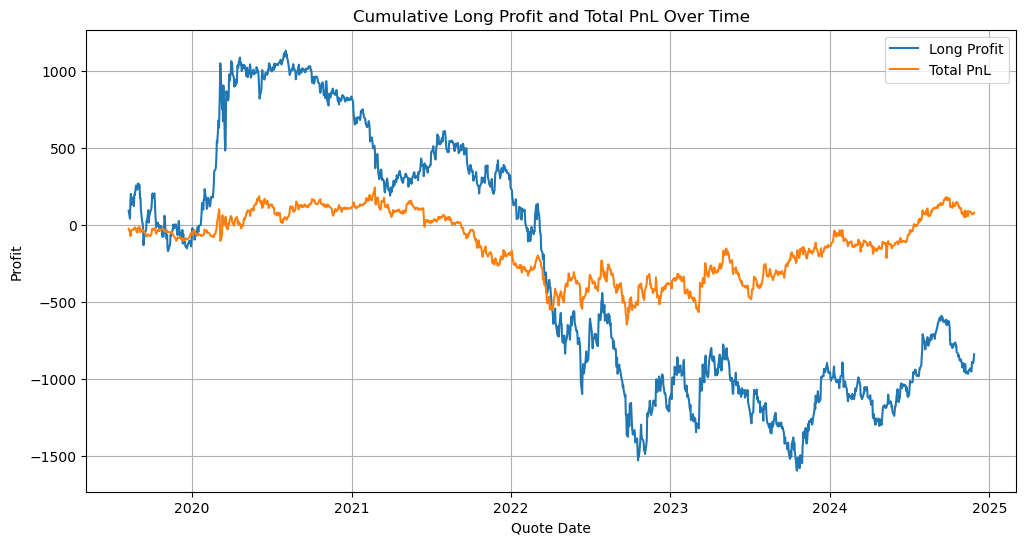

In [32]:
position.index = pd.to_datetime(position.index)

plt.figure(figsize=(12, 6))
plt.plot(position.index, position['Long Cumulative PnL'], label='Long Profit', linestyle='-')
plt.plot(position.index, position['Total Cumulative PnL'], label='Total PnL', linestyle='-')
plt.title('Cumulative Long Profit and Total PnL Over Time')
plt.xlabel('Quote Date')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

In [33]:
def performance_metrics(returns, ann):
    metrics = pd.DataFrame(index = returns.columns)
    
    metrics["Mean"] = returns.mean() * float(ann)
    metrics["Vol"] = returns.std() * float(np.sqrt(ann))
    metrics["Sharpe"] = returns.mean() / returns.std() * float(np.sqrt(ann))
    metrics["Max"] = returns.max()
    metrics["Min"] = returns.min()
    
    return metrics

In [34]:
performance_metrics(position[['Long Profit', 'Total PnL']], 1)

,Mean,Vol,Sharpe,Max,Min
Long Profit,-0.631149,44.589519,-0.014155,276.272207,-321.203791
Total PnL,0.059955,21.090467,0.002843,118.431025,-98.341110


### 2.3.

Give two reasons that the daily PnL is not always zero for the hedged position given that we have perfectly hedged the duration.

One reason is large shifts in the yield curve. Duration does a bad job of hedging against large parallel shifts in the yield curve since we didn't account for any second degree movements, Convexity, which start to dominate after large shifts. So large parallel movements is one reason that it doesn't have a PnL of 0.

The other reason is that there are convex instruments, and even if there isn't a massive move, the duration is changing throughout the day and this is not a static measure (just like Delta). So unless we hedge every second of the day, the PnL won't be 0, but it will still be very close to 0. Since we are using yesterday's metric for today's PnL and duration is not static, we see these changes often.

Another reason that is detached from this is that we are looking at market data where supply and demand metrics matter. This means that prices will also vary from liquidity or demand constraints on the bond, not only interest rate risk. This is another reason why we may see the PnL not exactly be 0.

### 2.4.
The PnL above doesn't account for the coupons.

Calculate a dataframe indexed by dates with columns for the two treasuries with values of coupon payments. 
* Recall that the stated coupon rate is semiannual, so at any give coupon date, it pays half the stated rate.
* Figure out the coupon dates by using the `data` tab and looking for dates where `acc int` goes down. Recall that accrued interest measures the portion of the coupon period that has passed. So when this resets, it is because the coupon has been paid.

Report the first 5 dates that a coupon is paid (by either bond).

In [35]:
data = data.set_index("quote date")
data = data.sort_index()
data

,KYTREASNO,type,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,duration
quote date,,,,,,,,,,,,,,
2019-08-08,207391,note,2019-08-15,2029-08-15,10.020534,0.000000,1.625,99.117188,99.179688,99.148438,0.000000,99.148438,0.017142,9.293501
2019-08-09,207391,note,2019-08-15,2029-08-15,10.017796,0.000000,1.625,98.851562,98.914062,98.882812,0.000000,98.882812,0.017438,9.289497
2019-08-09,207392,bond,2019-08-15,2049-08-15,30.017796,0.000000,2.250,99.757812,99.820312,99.789062,0.000000,99.789062,0.022578,22.000102
2019-08-12,207391,note,2019-08-15,2029-08-15,10.009582,0.000000,1.625,99.765625,99.828125,99.796875,0.000000,99.796875,0.016454,9.285468
2019-08-12,207392,bond,2019-08-15,2049-08-15,30.009582,0.000000,2.250,102.523438,102.585938,102.554688,0.000000,102.554688,0.021332,22.118496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26,207392,bond,2019-08-15,2049-08-15,24.717317,0.559783,2.250,65.140625,65.210938,65.175781,0.629755,65.805537,0.046303,17.295472
2024-11-27,207391,note,2019-08-15,2029-08-15,4.714579,0.565217,1.625,89.417969,89.457031,89.437500,0.459239,89.896739,0.041130,4.526701
2024-11-27,207392,bond,2019-08-15,2049-08-15,24.714579,0.565217,2.250,65.625000,65.687500,65.656250,0.635870,66.292120,0.045875,17.325380


In [36]:
long = data[data["KYTREASNO"]==207391]
short = data[data["KYTREASNO"]==207392]

long["coupon date"] = long["accrued int"].shift() > long["accrued int"]
short["coupon date"] = short["accrued int"].shift() > short["accrued int"]

long["coupon paid"] = long["coupon date"] * long["cpn rate"]/2
short["coupon paid"] = short["coupon date"] * short["cpn rate"]/2

long[long["coupon date"]].head(5)

/var/folders/2v/x2l6x6852t599bjnhqck84ch0000gn/T/ipykernel_97466/1726555020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long["coupon date"] = long["accrued int"].shift() > long["accrued int"]
/var/folders/2v/x2l6x6852t599bjnhqck84ch0000gn/T/ipykernel_97466/1726555020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short["coupon date"] = short["accrued int"].shift() > short["accrued int"]
/var/folders/2v/x2l6x6852t599bjnhqck84ch0000gn/T/ipykernel_97466/1726555020.py:7: SettingWithCopyWarning: 
A 

,KYTREASNO,type,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,duration,coupon date,coupon paid
quote date,,,,,,,,,,,,,,,,
2020-02-18,207391,note,2019-08-15,2029-08-15,9.489391,0.016484,1.625,100.546875,100.609375,100.578125,0.013393,100.591518,0.015596,8.839452,True,0.8125
2020-08-17,207391,note,2019-08-15,2029-08-15,8.993840,0.010870,1.625,108.781250,108.843750,108.812500,0.008832,108.821332,0.006164,8.439614,True,0.8125
2021-02-16,207391,note,2019-08-15,2029-08-15,8.492813,0.005525,1.625,103.882812,103.945312,103.914062,0.004489,103.918551,0.011410,7.984477,True,0.8125
2021-08-16,207391,note,2019-08-15,2029-08-15,7.997262,0.005435,1.625,103.851562,103.914062,103.882812,0.004416,103.887228,0.011161,7.547822,True,0.8125
2022-02-15,207391,note,2019-08-15,2029-08-15,7.496235,0.000000,1.625,97.242188,97.304688,97.273438,0.000000,97.273438,0.020196,7.085344,True,0.8125


In [37]:
short[short["coupon date"]].head(5)

,KYTREASNO,type,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,duration,coupon date,coupon paid
quote date,,,,,,,,,,,,,,,,
2020-02-18,207392,bond,2019-08-15,2049-08-15,29.489391,0.016484,2.25,105.234375,105.296875,105.265625,0.018544,105.284169,0.020125,21.951685,True,1.125
2020-08-17,207392,bond,2019-08-15,2049-08-15,28.993840,0.010870,2.25,119.648438,119.710938,119.679688,0.012228,119.691916,0.014196,22.219226,True,1.125
2021-02-16,207392,bond,2019-08-15,2049-08-15,28.492813,0.005525,2.25,103.789062,103.851562,103.820312,0.006215,103.826528,0.020722,21.357718,True,1.125
2021-08-16,207392,bond,2019-08-15,2049-08-15,27.997262,0.005435,2.25,106.996094,107.058594,107.027344,0.006114,107.033458,0.019241,21.213414,True,1.125
2022-02-15,207392,bond,2019-08-15,2049-08-15,27.496235,0.000000,2.25,97.125000,97.187500,97.156250,0.000000,97.156250,0.023921,20.545893,True,1.125


### 2.5.
Account for the coupons in the PnL calculations of `2.2`. Report the updated PnL in a plot and a table, similar to the reporting in `2.2`.

In [38]:
long_coupons = long[["coupon paid"]]
long_coupons.columns = ["Long Coupon"]
short_coupons = short[["coupon paid"]]
short_coupons.columns = ["Short Coupon"]

In [39]:
position = pd.DataFrame(index=duration.index, dtype=float)
position["Long"] = N/tdata["207391_price"]
position["Short"] = -position["Long"] * (tdata["207391_price"] * tdata["207391_duration"])/(tdata["207392_price"] * tdata["207392_duration"])
position["Long Value"] = position["Long"] * tdata["207391_price"]
position["Short Value"] = position["Short"] * tdata["207392_price"]
position["Long Trade"] = position["Long"] * tdata["207391_price"].shift(-1)
position["Short Trade"] = position["Short"] * tdata["207392_price"].shift(-1)
position.head()

,Long,Short,Long Value,Short Value,Long Trade,Short Trade
quote date,,,,,,
2019-08-09,101.129810,-42.314047,10000.0,-4222.479083,10092.438967,-4339.503869
2019-08-12,100.203538,-40.934802,10000.0,-4198.055835,9948.332550,-4169.913158
2019-08-13,100.723953,-41.251958,10000.0,-4202.220951,10113.314448,-4338.868062
2019-08-14,99.595394,-39.703946,10000.0,-4176.048586,10047.463430,-4217.923841
2019-08-15,99.124913,-39.232518,10000.0,-4167.842047,9975.993185,-4110.525790


In [40]:
t1 = position.join(long_coupons)
tdata = t1.join(short_coupons)
position = tdata
position.head()

,Long,Short,Long Value,Short Value,Long Trade,Short Trade,Long Coupon,Short Coupon
quote date,,,,,,,,
2019-08-09,101.129810,-42.314047,10000.0,-4222.479083,10092.438967,-4339.503869,0.0,0.0
2019-08-12,100.203538,-40.934802,10000.0,-4198.055835,9948.332550,-4169.913158,0.0,0.0
2019-08-13,100.723953,-41.251958,10000.0,-4202.220951,10113.314448,-4338.868062,0.0,0.0
2019-08-14,99.595394,-39.703946,10000.0,-4176.048586,10047.463430,-4217.923841,0.0,0.0
2019-08-15,99.124913,-39.232518,10000.0,-4167.842047,9975.993185,-4110.525790,0.0,0.0


In [41]:
position["Long Profit"] = position["Long Trade"] - position["Long Value"] + position["Long"] * position["Long Coupon"]
position["Short Profit"] = position["Short Trade"] - position["Short Value"] + position["Short"] * position["Short Coupon"]
position["Total PnL"] = position["Long Profit"] + position["Short Profit"]
position["Total Cumulative PnL"] = position["Total PnL"].cumsum()
position["Long Cumulative PnL"] = position["Long Profit"].cumsum()
position

,Long,Short,Long Value,Short Value,Long Trade,Short Trade,Long Coupon,Short Coupon,Long Profit,Short Profit,Total PnL,Total Cumulative PnL,Long Cumulative PnL
quote date,,,,,,,,,,,,,
2019-08-09,101.129810,-42.314047,10000.0,-4222.479083,10092.438967,-4339.503869,0.0,0.0,92.438967,-117.024786,-24.585820,-24.585820,92.438967
2019-08-12,100.203538,-40.934802,10000.0,-4198.055835,9948.332550,-4169.913158,0.0,0.0,-51.667450,28.142676,-23.524773,-48.110593,40.771517
2019-08-13,100.723953,-41.251958,10000.0,-4202.220951,10113.314448,-4338.868062,0.0,0.0,113.314448,-136.647111,-23.332664,-71.443256,154.085965
2019-08-14,99.595394,-39.703946,10000.0,-4176.048586,10047.463430,-4217.923841,0.0,0.0,47.463430,-41.875255,5.588175,-65.855082,201.549394
2019-08-15,99.124913,-39.232518,10000.0,-4167.842047,9975.993185,-4110.525790,0.0,0.0,-24.006815,57.316257,33.309442,-32.545640,177.542580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22,112.688456,-41.403909,10000.0,-2638.367073,10061.626499,-2706.942298,0.0,0.0,61.626499,-68.575225,-6.948725,482.588799,-34.901181
2024-11-25,111.998250,-40.040242,10000.0,-2617.787204,9991.906379,-2609.654032,0.0,0.0,-8.093621,8.133172,0.039551,482.628351,-42.994801
2024-11-26,112.088971,-40.178741,10000.0,-2618.680845,10024.957304,-2637.985475,0.0,0.0,24.957304,-19.304630,5.652675,488.281025,-18.037497


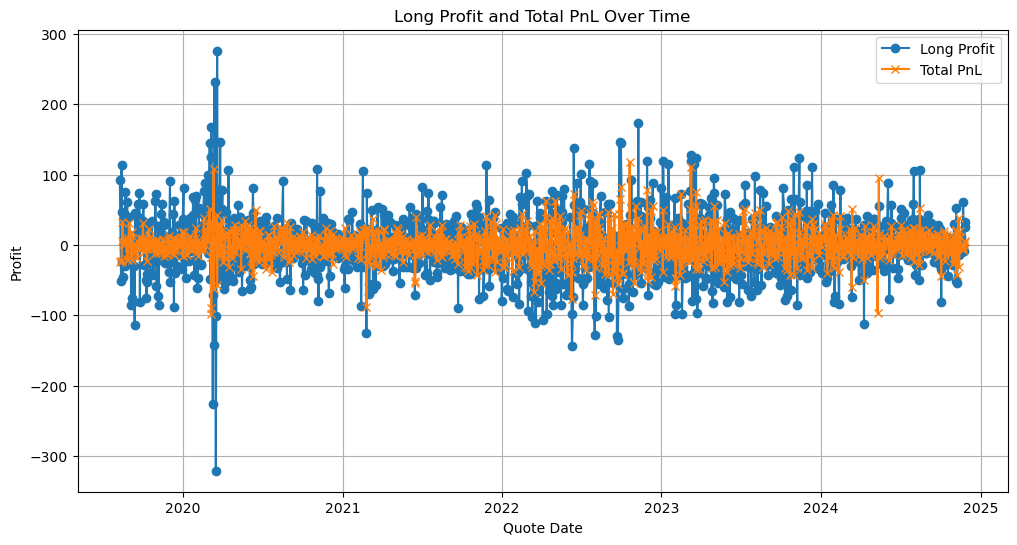

In [42]:
position.index = pd.to_datetime(position.index)

plt.figure(figsize=(12, 6))
plt.plot(position.index, position['Long Profit'], label='Long Profit', linestyle='-', marker='o')
plt.plot(position.index, position['Total PnL'], label='Total PnL', linestyle='-', marker='x')
plt.title('Long Profit and Total PnL Over Time')
plt.xlabel('Quote Date')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

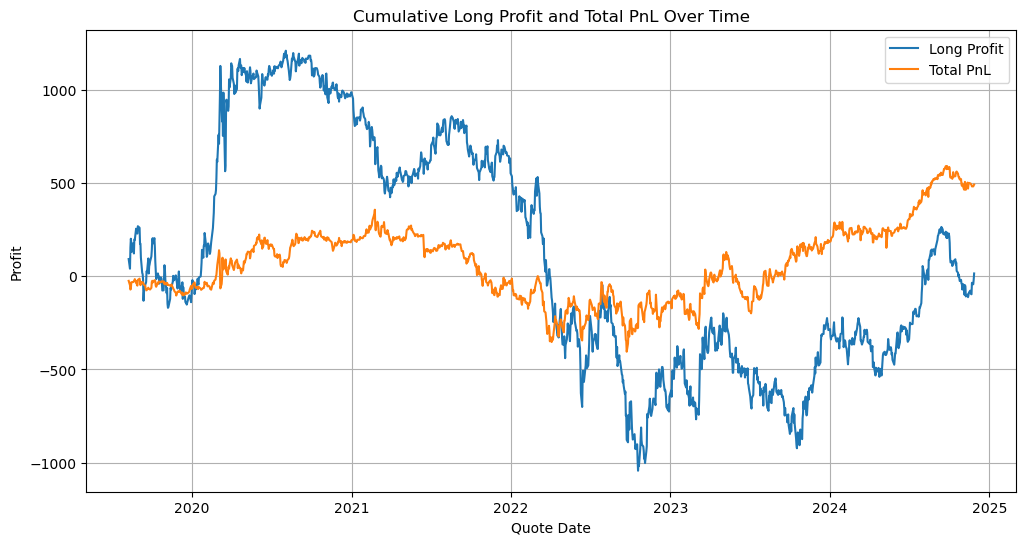

In [43]:
position.index = pd.to_datetime(position.index)

plt.figure(figsize=(12, 6))
plt.plot(position.index, position['Long Cumulative PnL'], label='Long Profit', linestyle='-')
plt.plot(position.index, position['Total Cumulative PnL'], label='Total PnL', linestyle='-')
plt.title('Cumulative Long Profit and Total PnL Over Time')
plt.xlabel('Quote Date')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

In [44]:
performance_metrics(position[['Long Profit', 'Total PnL']], 1)

,Mean,Vol,Sharpe,Max,Min
Long Profit,0.011404,45.176847,0.000252,276.272207,-321.203791
Total PnL,0.370626,21.355714,0.017355,118.431025,-98.341110
